In [1]:
import pandas as pd
import requests
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from matplotlib.pylab import plt
import numpy as np
%matplotlib inline
import warnings
import geopandas as gpd
from urllib.request import urlopen 
import json
import urllib
warnings.filterwarnings('ignore')
from zipfile import ZipFile
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import urllib
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np
from scipy.signal import periodogram
import statsmodels.api as sm
import dask.dataframe as dd

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import warnings
warnings.filterwarnings('ignore')

### Incidents Responded to by Fire Companies

In [2]:
IncidentsRespTo = pd.read_csv('Incidents_Responded_to_by_Fire_Companies_Cleaned.csv')

In [3]:
IncidentsRespTo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5085930 entries, 0 to 5085929
Data columns (total 16 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   IM_INCIDENT_KEY              int64  
 1   FIRE_BOX                     object 
 2   INCIDENT_TYPE_DESC           object 
 3   INCIDENT_DATE_TIME           object 
 4   ARRIVAL_DATE_TIME            object 
 5   UNITS_ONSCENE                float64
 6   LAST_UNIT_CLEARED_DATE_TIME  object 
 7   HIGHEST_LEVEL_DESC           object 
 8   TOTAL_INCIDENT_DURATION      float64
 9   ACTION_TAKEN1_DESC           object 
 10  ACTION_TAKEN2_DESC           object 
 11  PROPERTY_USE_DESC            object 
 12  STREET_HIGHWAY               object 
 13  ZIP_CODE                     int64  
 14  BOROUGH_DESC                 object 
 15  FLOOR                        object 
dtypes: float64(2), int64(2), object(12)
memory usage: 620.8+ MB


#### Incidents Types

In [4]:
(IncidentsRespTo.INCIDENT_TYPE_DESC.value_counts(normalize=True,ascending=False)*100).head(15)

INCIDENT_TYPE_DESC
300 - Rescue, EMS incident, other                               37.925669
651 - Smoke scare, odor of smoke                                 5.535448
735A - Unwarranted alarm/defective condition of alarm system     5.176300
710 - Malicious, mischievous false call, other                   4.992971
522 - Water or steam leak                                        4.361189
412 - Gas leak (natural gas or LPG)                              4.315691
113 - Cooking fire, confined to container                        3.709607
353 - Removal of victim(s) from stalled elevator                 3.697062
555 - Defective elevator, no occupants                           2.203098
736 - CO detector activation due to malfunction                  2.015030
322 - Motor vehicle accident with injuries                       1.893656
353S - Stalled occupied elevator-removal via hoistway door       1.729969
445 - Arcing, shorted electrical equipment                       1.460500
740A - Unnecessary 

37.93% of the incidents are related to Rescue, EMS incident, other. 5.53% of the incidents are related to smoke scare, odor of smoke. Interestingly, 5.18% of the calls were about unwarranted alarm/defective condition of alarm system.

In [5]:
# Check all Incident Types
IncidentsRespTo.INCIDENT_TYPE_DESC.unique()

array(['300 - Rescue, EMS incident, other',
       '735A - Unwarranted alarm/defective condition of alarm system',
       '412 - Gas leak (natural gas or LPG)',
       '353 - Removal of victim(s) from stalled elevator',
       '651 - Smoke scare, odor of smoke',
       '331 - Lock-in (if lock out , use 511 )',
       '710 - Malicious, mischievous false call, other',
       '555 - Defective elevator, no occupants',
       '522 - Water or steam leak', '150 - Outside rubbish fire, other',
       '151 - Outside rubbish, trash or waste fire',
       '118 - Trash or rubbish fire, contained',
       '322 - Motor vehicle accident with injuries',
       '746 - Carbon monoxide detector activation, no CO',
       '142 - Brush or brush-and-grass mixture fire',
       '321 - EMS call, excluding vehicle accident with injury',
       '311 - Medical assist, assist EMS crew',
       '113 - Cooking fire, confined to container', '100 - Fire, other',
       '323 - Motor vehicle/pedestrian accident (MV Ped

In [6]:
total_null_ArrTime = IncidentsRespTo[IncidentsRespTo.ARRIVAL_DATE_TIME.isnull()]['IM_INCIDENT_KEY'].count()
print("Total Percentage of Missing Arrival Time", round(total_null_ArrTime/len(IncidentsRespTo)*100,2),"%")

Total Percentage of Missing Arrival Time 2.64 %


In [7]:
# False Alarm, Check incident types 
IncidentsRespTo[IncidentsRespTo.INCIDENT_TYPE_DESC.str.contains('false', case=False)]['INCIDENT_TYPE_DESC'].unique()

array(['710 - Malicious, mischievous false call, other',
       '700 - False alarm or false call, other',
       '711 - Municipal alarm system, malicious false alarm',
       '713 - Telephone, malicious false alarm',
       '715 - Local alarm system, malicious false alarm',
       '714 - Central station, malicious false alarm',
       '712 - Direct tie to FD, malicious false alarm',
       '751 - Biological hazard, malicious false report'], dtype=object)

In [8]:
total_false_incidents=IncidentsRespTo.INCIDENT_TYPE_DESC.str.contains('false', case=False).sum()
print("Total Percentage of False Alarms", round(total_false_incidents/len(IncidentsRespTo)*100,2),"%")

Total Percentage of False Alarms 5.08 %


In [9]:
IncidentsRespTo[IncidentsRespTo.INCIDENT_TYPE_DESC.str.contains('Unnecessary alarm', case=False)]['INCIDENT_TYPE_DESC'].unique()

array(['735B - Unnecessary alarm/alarm system testing or servicing',
       '740B - Unnecessary alarm/other known cause',
       '740A - Unnecessary alarm/construction activities',
       '745A - Unnecessary alarm/ordinary household activities'],
      dtype=object)

In [10]:
total_unnecessary_incidents = IncidentsRespTo.INCIDENT_TYPE_DESC.str.contains('Unnecessary alarm', case=False).sum()
print("Total Percentage of Unnecessary Alarms", round(total_unnecessary_incidents/len(IncidentsRespTo)*100,2),"%")

Total Percentage of Unnecessary Alarms 3.28 %


#### Geographical Analysis

In [11]:
# Read map 
zips = gpd.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')
zips['ZIPCODE']=zips['ZIPCODE'].astype(int)

In [12]:
IncidByZip = IncidentsRespTo[['IM_INCIDENT_KEY','ZIP_CODE']].groupby(by = 'ZIP_CODE', as_index=False).count()
IncidByZip.rename(columns = {'IM_INCIDENT_KEY':'N_Incident'},inplace=True)

In [13]:
IncidByZip = zips.merge(IncidByZip,left_on = 'ZIPCODE',right_on='ZIP_CODE')
IncidByZip = IncidByZip.drop_duplicates(subset='ZIPCODE')
IncidByZip['IncidRate'] = IncidByZip['N_Incident']/(IncidByZip['POPULATION']/100000)

Text(0.5, 1.0, 'The Fire Incident Counts')

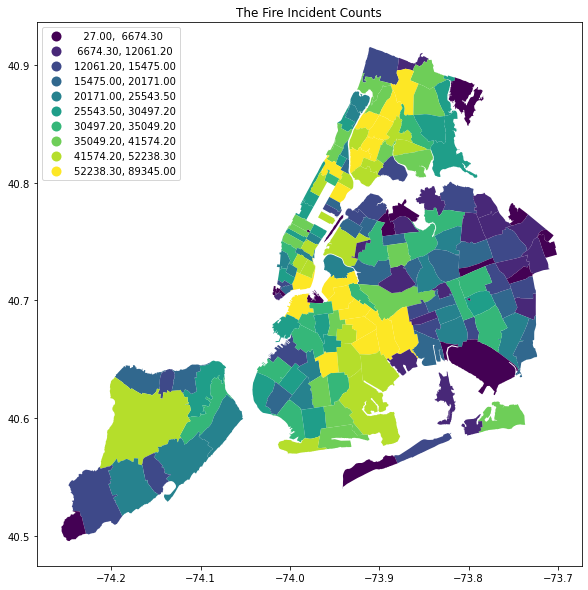

In [14]:
# plot as a heatmap with quantiles color scheme
fig, ax = plt.subplots(1, figsize=(10,10))
IncidByZip.to_crs({'init': 'epsg:4326'}).plot(ax=ax, column='N_Incident',k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})
plt.title('The Fire Incident Counts')

Text(0.5, 1.0, 'The Fire Incident Counts normalized by population (per 100,000)')

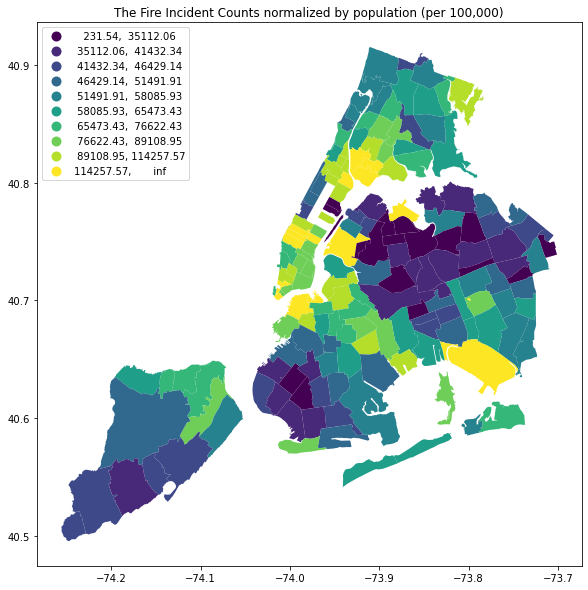

In [15]:
# plot as a heatmap with quantiles color scheme
fig, ax = plt.subplots(1, figsize=(10,10))
IncidByZip.to_crs({'init': 'epsg:4326'}).plot(ax=ax, column='IncidRate',k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})
plt.title('The Fire Incident Counts normalized by population (per 100,000)')

#### Response Time of the On Scene Units

In [16]:
# Convert Data-time fields to correct data type
IncidentsRespTo['INCIDENT_DATE_TIME'] = pd.to_datetime(IncidentsRespTo['INCIDENT_DATE_TIME'])
IncidentsRespTo['ARRIVAL_DATE_TIME'] = pd.to_datetime(IncidentsRespTo['ARRIVAL_DATE_TIME'])

In [17]:
IncidentsRespTo['Response_Time']=(IncidentsRespTo['ARRIVAL_DATE_TIME'] - IncidentsRespTo['INCIDENT_DATE_TIME']).dt.seconds/60

In [18]:
IncidentsRespTo['Response_Time'].describe().round(2)

count    4951687.00
mean           5.49
std            5.53
min            0.07
25%            3.88
50%            4.88
75%            6.18
max         1436.98
Name: Response_Time, dtype: float64

- The average response time is approximately 5.49 minutes.
- The standard deviation is 5.53 minutes.
- The minimum recorded response time is 0.07 minutes.
- A quarter of the incidents have a response time of 3.88 minutes or less.
- Half the incidents have a shorter response time and the other half have a longer response time than 4.88 minutes.
- Three-quarters of the incidents have a response time of 6.18 minutes or less.
- The maximum response time is extremely high at 1436.98 minutes, suggesting outlier cases with unusually long response times.

#### Incident Duration Time

In [19]:
# Check total duration in min
(IncidentsRespTo['TOTAL_INCIDENT_DURATION']/60).describe().round(2)

count    5084406.00
mean          24.08
std           52.75
min            0.00
25%           12.47
50%           17.52
75%           26.08
max        28607.73
Name: TOTAL_INCIDENT_DURATION, dtype: float64

#### Time-series exploratory analysis

In [20]:
IncidentsRespTo['INCIDENT_DATE_ByDay'] = IncidentsRespTo.INCIDENT_DATE_TIME.dt.to_period('D')

In [21]:
IncidentsDaily = IncidentsRespTo[['IM_INCIDENT_KEY','INCIDENT_DATE_ByDay']].groupby(by = 'INCIDENT_DATE_ByDay').count()
IncidentsDaily.index = IncidentsDaily.index.to_timestamp()
IncidentsDaily.head()

,IM_INCIDENT_KEY
INCIDENT_DATE_ByDay,
2013-01-01,1250
2013-01-02,1061
2013-01-03,1066
2013-01-04,1079
2013-01-05,1059


In [22]:
# get the number of samples
nsamp = len(IncidentsDaily)

# convert the `date` feature into `dt.datetime` format. This is for later datetime operations
Time =IncidentsDaily.index.values

# print dataset characteristics
print('This is the original dataset characteristics:')
timeperiod = Time[-1] - Time[0] + pd.to_timedelta(1,unit='day')

# this is the duration of our observations: tail - head + 1 
print('The time period for this dataset is: ', timeperiod.days)
print('The number of observations are: ', nsamp)
print(IncidentsDaily.describe())

This is the original dataset characteristics:
The time period for this dataset is:  3986
The number of observations are:  3986
       IM_INCIDENT_KEY
count      3986.000000
mean       1275.948319
std         172.794137
min         734.000000
25%        1178.000000
50%        1266.000000
75%        1354.000000
max        3596.000000


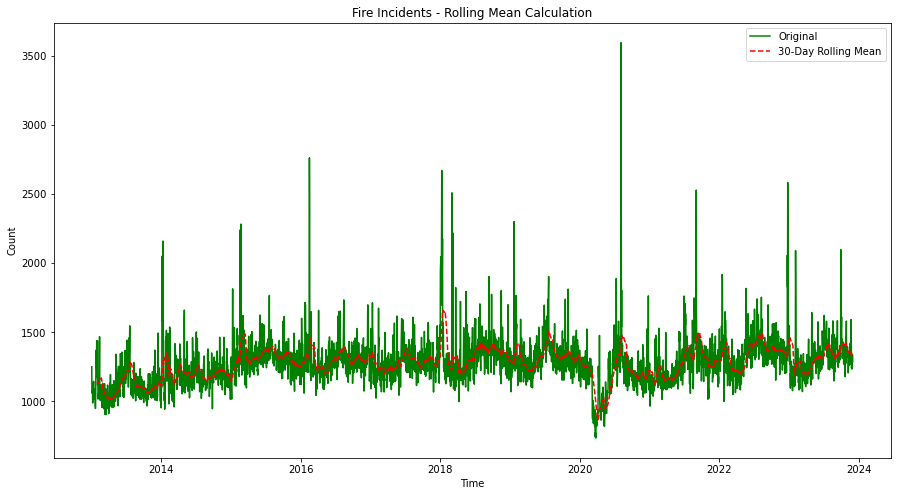

In [23]:
import matplotlib.pyplot as plt
from importlib import reload
plt = reload(plt)  # Ensure plt is reloaded, if needed

xTime = IncidentsDaily.index.values
yIncidents = IncidentsDaily['IM_INCIDENT_KEY'].values

# Define the window size
window_size = 30

# Calculation of rolling mean
rolling_means = np.array([yIncidents[i:i+window_size].mean() for i in range(len(yIncidents) - window_size + 1)])
# Create a new time series for the rolling mean to align with the center of the windows
rolling_time = xTime[window_size-1:]

# Plotting
plt.figure(figsize=(15, 8))
plt.title('Fire Incidents - Rolling Mean Calculation')
plt.plot(xTime, yIncidents, label='Original', color='green')
plt.plot(rolling_time, rolling_means, label='30-Day Rolling Mean', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()

#### Trend and seasonality

In [24]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt

f, PSD = periodogram(IncidentsDaily['IM_INCIDENT_KEY'])
PSD = PSD[f>0.005]
f = f[f>0.005]
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)]))

Strongest period length = 181.1818181818182


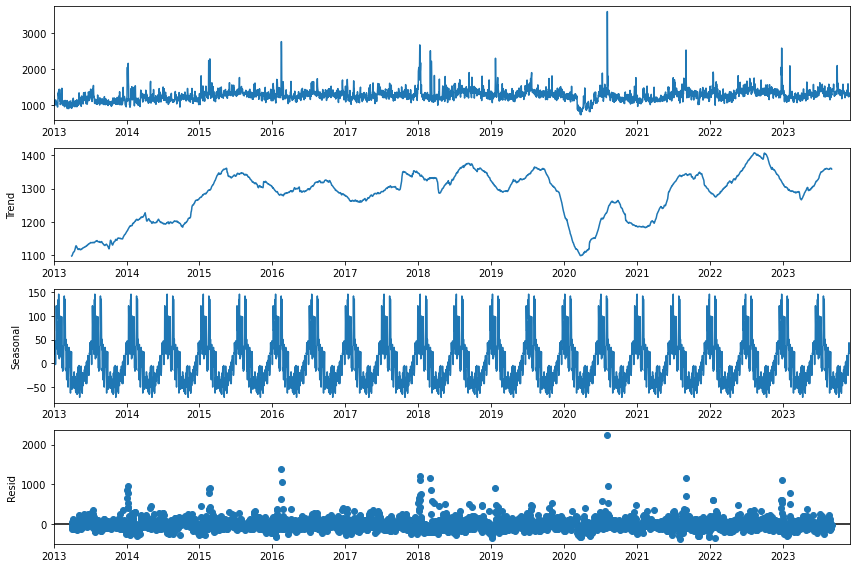

In [25]:
matplotlib.rcParams['figure.figsize'] = [12, 8]
res = sm.tsa.seasonal_decompose(IncidentsDaily,model='additive', period=181)
res.plot()
plt.show()

#### Predict the total daily fire incidents using ARIMA

In [26]:
# adfuller test to test the stability of the aggregated dataset
result = adfuller(IncidentsDaily.values)
print('p-value: %f' % result[1])

p-value: 0.000000


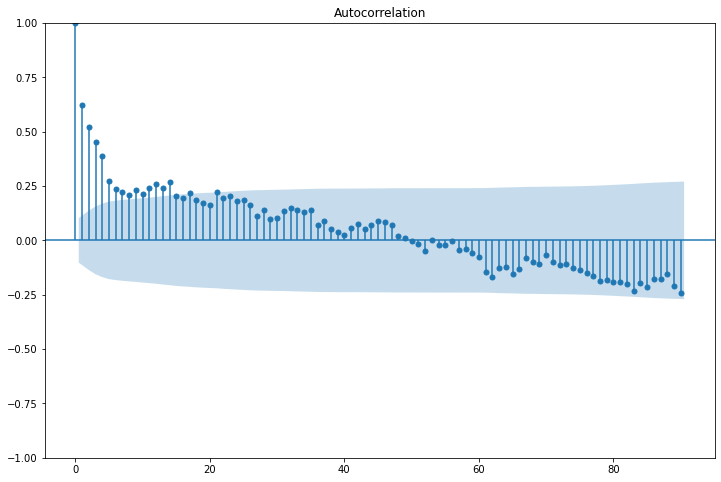

In [27]:
# Find the MA term (p)
plot_acf(IncidentsDaily['IM_INCIDENT_KEY'][:365], lags = 90); 

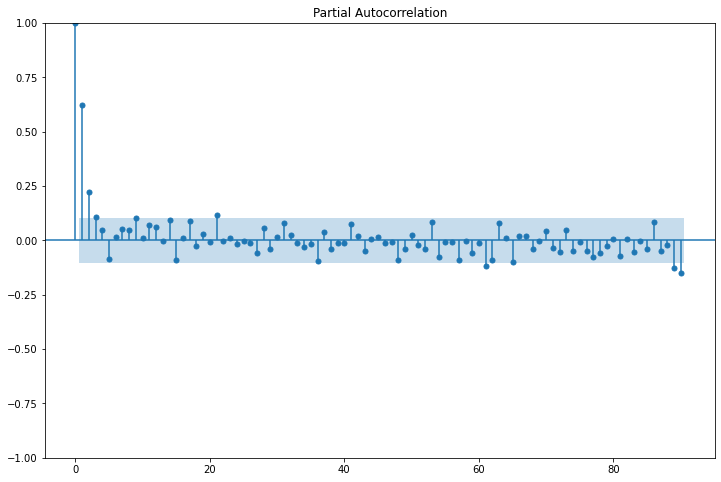

In [28]:
# Find the AR term (q)
plot_pacf(IncidentsDaily['IM_INCIDENT_KEY'][:365], lags = 90); 

In [29]:
series = IncidentsDaily['IM_INCIDENT_KEY']

In [30]:
# Train on first 80% of the data
train_size = int(IncidentsDaily.shape[0]*0.8)

                               SARIMAX Results                                
Dep. Variable:        IM_INCIDENT_KEY   No. Observations:                 3188
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -19997.120
Date:                Mon, 08 Apr 2024   AIC                          40002.241
Time:                        15:02:29   BIC                          40026.509
Sample:                    01-01-2013   HQIC                         40010.943
                         - 09-23-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1262.1233     11.395    110.761      0.000    1239.789    1284.457
ar.L1          0.8144      0.009     86.362      0.000       0.796       0.833
ma.L1         -0.2639      0.015    -17.825      0.0

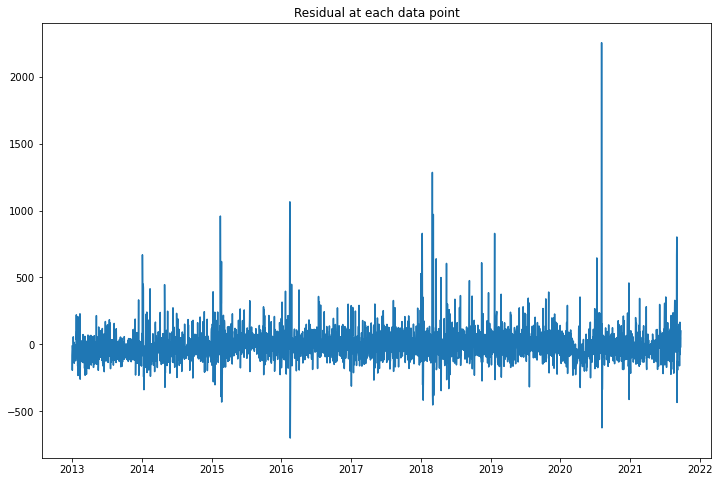

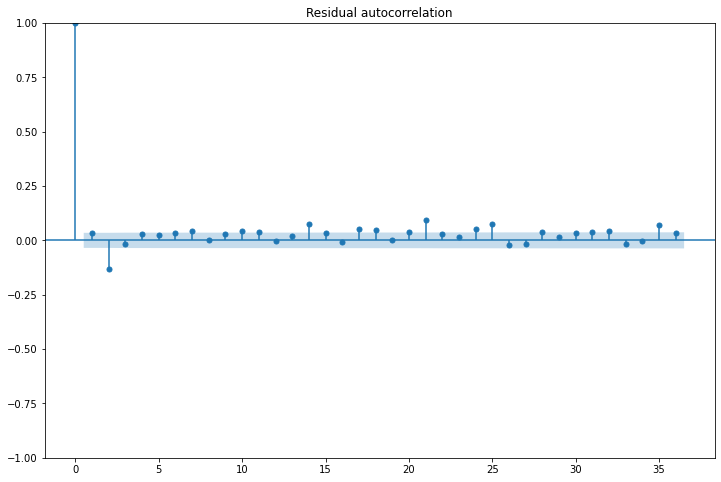

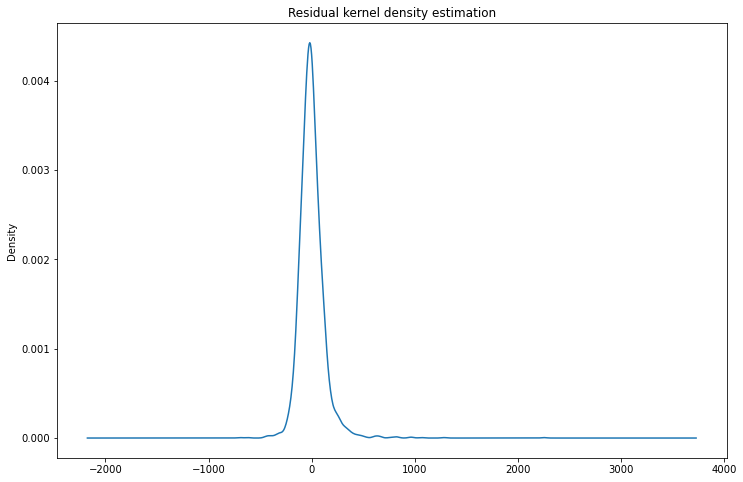

                 0
count  3188.000000
mean      0.048994
std     128.219341
min    -698.879397
25%     -68.418901
50%     -12.270843
75%      52.962060
max    2253.424450
p value is  0.0
null hypothesis: residuals comes from a normal distribution
The null hypothesis can be rejected


In [31]:
import scipy
P=1
D=0
Q=1

# fit model
N = train_size

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# plt.figure(figsize = (6,4))
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals comes from a normal distribution')
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [32]:
# Forecast
fcast = model_fit.forecast(steps=len(series)-N)  # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()
fc_series = pd.Series(fc['mean'])
fc_series.index = IncidentsDaily.index[N:]

lower_series = pd.Series(fc.mean_ci_lower, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper, index=range(N,len(series)))

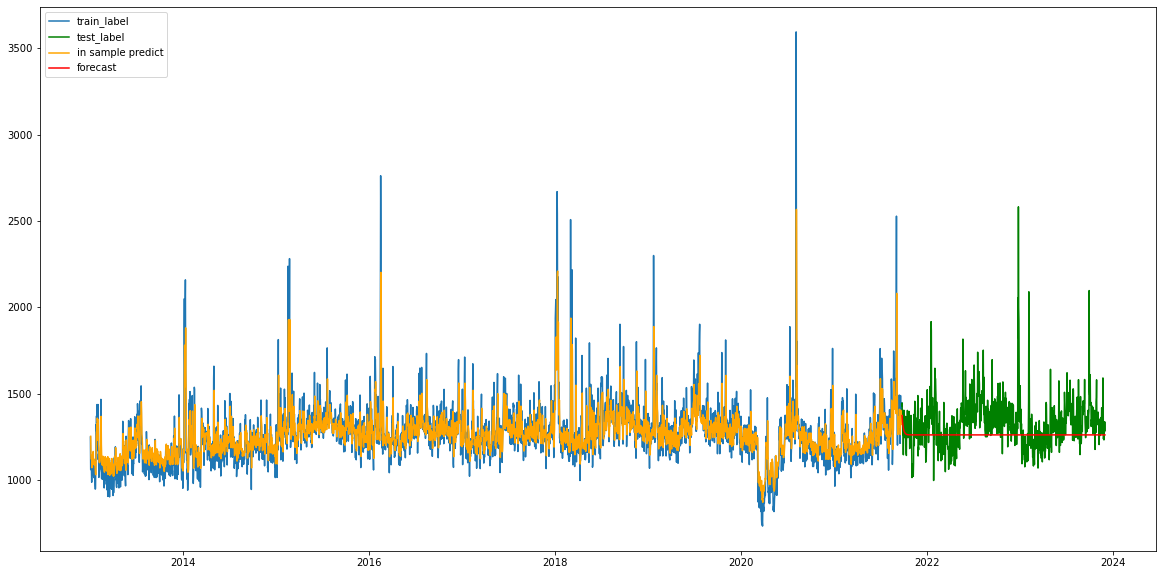

In [33]:
plt.rcParams.update({'figure.figsize':(20,10)})
# plt.plot(series)

# plt.plot(series)
plt.plot(IncidentsDaily.index[:N+1].values,series[:N+1].values,label='train_label')
plt.plot(IncidentsDaily.index[N-1:].values,series[N-1:].values,color='green',label='test_label')

plt.plot(IncidentsDaily.index[1:N+1].values,
         model_fit.predict(start=1,end=N,dynamic=False,typ='levels').values,
         color='orange',label='in sample predict')

plt.plot(IncidentsDaily.index[N:].values,
         fc_series.values.tolist(), label='forecast', color='red')
plt.legend(loc='upper left')

In [34]:
# In sample R2 score
r2_score(IncidentsDaily[1:N+1].values,
         model_fit.predict(start=1,end=N,dynamic=False,typ='levels').values) 

0.474003097272675

In [35]:
# Out of sample R2 score
r2_score(IncidentsDaily[N:].values,
         fc_series.values.tolist()) 

-0.22934106659311082

#### Normality Test for the Noise Distribution

In [36]:
# check the distribution of a sample of data is the histogram
from numpy.random import seed
from numpy.random import randn
addResult = sm.tsa.seasonal_decompose(IncidentsDaily,model='additive', period=181)
residualAdd = np.array(addResult.resid)
residualAdd = residualAdd[np.logical_not(np.isnan(residualAdd))]

In [37]:
multResult = sm.tsa.seasonal_decompose(IncidentsDaily,model='multiplicative', period=181)
residualMult = np.log10(np.array(multResult.resid))
residualMult = residualMult[np.logical_not(np.isnan(residualMult))]

In [38]:
# Use Kolmogorov-Smirnov test to compare empirical distributions vs the normal
scipy.stats.kstest(residualAdd, 'norm')

KstestResult(statistic=0.551291338874721, pvalue=0.0, statistic_location=-2.7980027461118055, statistic_sign=1)

In [39]:
scipy.stats.kstest(residualMult, 'norm')

KstestResult(statistic=0.4517840675937216, pvalue=0.0, statistic_location=-0.10789642036654146, statistic_sign=-1)

The p-values are way below 5% (and even 1% or 0.1%), so the normality hypothesis should be rejected at any reasonable significance level (probability of rejecting hypothesis when it'd be actually true).

#### Outlier Detection on Residual

In [40]:
dailyDecomp = sm.tsa.seasonal_decompose(IncidentsDaily,model='multiplicative', period=181)
dailyResid = dailyDecomp.resid
outlierData = pd.DataFrame({})
outlierData['Res'] = dailyResid
outlierData['Percentile_rank'] = outlierData.Res.rank(pct = True)-0.5

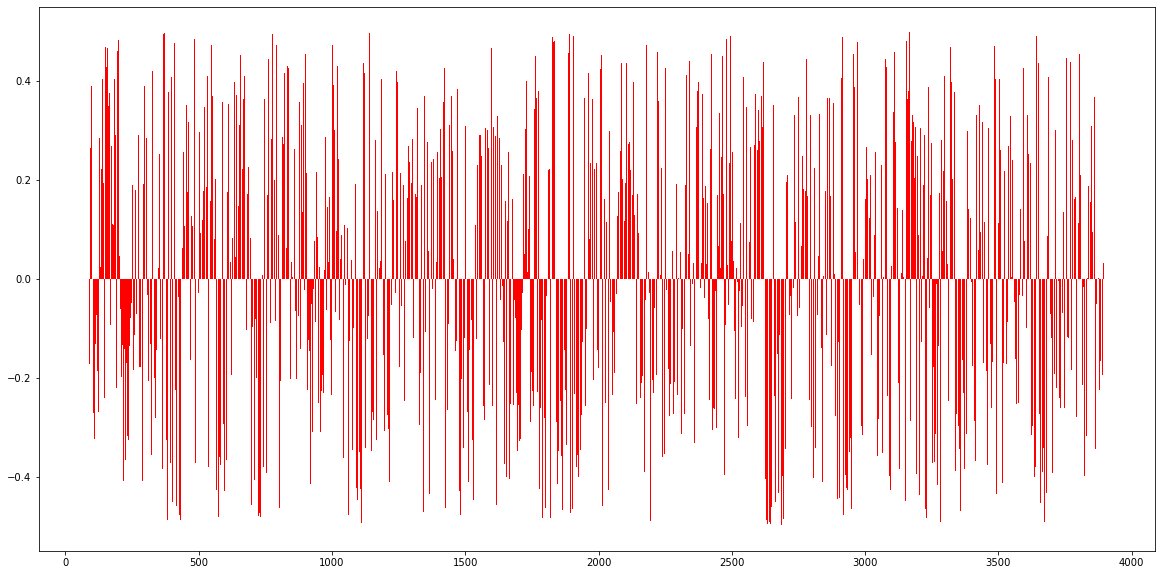

In [41]:
# based on percentile rank
plt.bar(np.arange(0, len(outlierData)), outlierData['Percentile_rank'], color='red')
plt.show()

In [42]:
# There is no certain definition of outliers, common methods include percentile, standard deviation, and IQR.
# In this case, we select 1% outliers.
outlier1 = IncidentsDaily[outlierData['Percentile_rank']>0.49]

In [43]:
# Listing outliers
outlier2 = IncidentsDaily[outlierData['Percentile_rank']<-0.49]

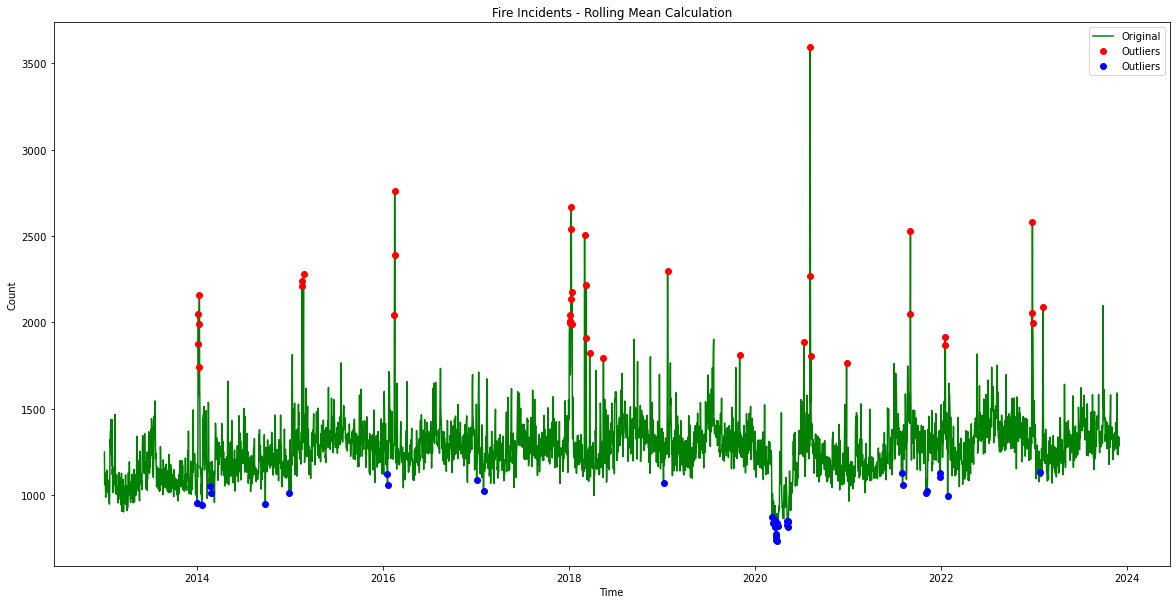

In [44]:
xTime = IncidentsDaily.index.values
yIncidents = IncidentsDaily['IM_INCIDENT_KEY'].values

# Plotting
plt.figure(figsize=(20, 10))
plt.title('Fire Incidents - Rolling Mean Calculation')
plt.plot(xTime, yIncidents, label='Original', color='green')
plt.plot(outlier1.index.values,outlier1['IM_INCIDENT_KEY'].values,'ro', label='Outliers')
plt.plot(outlier2.index.values,outlier2['IM_INCIDENT_KEY'].values,'bo', label='Outliers')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()

### Fire Incident Dispatch Data

In [45]:
IncidentsDispatch = pd.read_csv('Fire_Incident_Dispatch_Data_Cleaned.csv')

In [46]:
pd.set_option('display.max_columns', None)
IncidentsDispatch.head()

,STARFIRE_INCIDENT_ID,INCIDENT_DATETIME,ALARM_BOX_BOROUGH,ALARM_BOX_NUMBER,ALARM_BOX_LOCATION,INCIDENT_BOROUGH,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,ALARM_SOURCE_DESCRIPTION_TX,ALARM_LEVEL_INDEX_DESCRIPTION,HIGHEST_ALARM_LEVEL,INCIDENT_CLASSIFICATION,INCIDENT_CLASSIFICATION_GROUP,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ASSIGNMENT_DATETIME,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,INCIDENT_CLOSE_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,ENGINES_ASSIGNED_QUANTITY,LADDERS_ASSIGNED_QUANTITY,OTHER_UNITS_ASSIGNED_QUANTITY
0,2100404460110002,2021-01-04 00:01:00,MANHATTAN,446,3 AVE & ST. MARKS PL,MANHATTAN,10003.0,9.0,2.0,103.0,1.0,12.0,PD Link/Medical,Initial Alarm,First Alarm,Medical - PD Link 10-91,Medical Emergencies,13.0,2021-01-04 00:01:00,2021-01-04 00:02:00,NaN,2021-01-04 00:07:00,N,N,0.0,0.0,1.0,0.0,0.0
1,2100433250140001,2021-01-04 00:01:00,BROOKLYN,3325,AVENUE O & E 13 ST,BROOKLYN,11230.0,70.0,48.0,314.0,21.0,9.0,EMS Link/Medical,Initial Alarm,First Alarm,Medical - Breathing / Ill or Sick,Medical Emergencies,5.0,2021-01-04 00:01:00,2021-01-04 00:02:00,2021-01-04 00:04:00,2021-01-04 00:32:00,N,Y,170.0,165.0,1.0,0.0,0.0
2,2100411280150003,2021-01-04 00:01:00,QUEENS,1128,MOTT AVE & DICKENS ST,QUEENS,11691.0,101.0,31.0,414.0,27.0,5.0,EMS Link/Medical,Initial Alarm,First Alarm,Medical - EMS Link 10-91,Medical Emergencies,4.0,2021-01-04 00:01:00,2021-01-04 00:02:00,NaN,2021-01-04 00:05:00,N,N,0.0,0.0,1.0,0.0,0.0
3,2100416590110004,2021-01-04 00:02:00,MANHATTAN,1659,BROADWAY & 153 ST,MANHATTAN,10031.0,30.0,7.0,109.0,6.0,13.0,PD Link/Medical,Initial Alarm,First Alarm,Medical - Serious Life Threatening,Medical Emergencies,4.0,2021-01-04 00:02:00,2021-01-04 00:02:00,2021-01-04 00:07:00,2021-01-04 00:31:00,N,Y,318.0,314.0,1.0,0.0,0.0
4,2100413490110006,2021-01-04 00:02:00,MANHATTAN,1349,5 AVE & 112 ST,MANHATTAN,10026.0,28.0,9.0,110.0,3.0,13.0,EMS Link/Medical,Initial Alarm,First Alarm,Medical - Breathing / Ill or Sick,Medical Emergencies,37.0,2021-01-04 00:03:00,2021-01-04 00:03:00,2021-01-04 00:17:00,2021-01-04 00:18:00,N,Y,871.0,834.0,1.0,0.0,0.0


#### Alarm Types and Incident Types

In [47]:
(IncidentsDispatch.HIGHEST_ALARM_LEVEL.value_counts(normalize=True,ascending=False)*100)

HIGHEST_ALARM_LEVEL
First Alarm              99.297785
All Hands Working         0.424810
Seventh Alarm             0.238162
Second Alarm              0.028275
Third Alarm               0.006100
Fourth Alarm              0.002001
Fifth Alarm or Higher     0.001133
Fifth Alarm               0.001064
Complaint/Still           0.000572
Simultaneous Call         0.000039
Sixth Alarm               0.000039
Eighth Alarm              0.000010
Ninth Alarm or Higher     0.000010
Name: proportion, dtype: float64

In [48]:
(IncidentsDispatch.ALARM_SOURCE_DESCRIPTION_TX.value_counts(normalize=True,ascending=False)*100)

ALARM_SOURCE_DESCRIPTION_TX
EMS Link/Medical      19.467415
PD Link/Medical       18.732954
Phone                 18.611272
UCT/911               15.142289
Private Fire Alarm     7.565044
EMS                    5.191746
PHONE                  4.726264
EMS-911                3.306066
Verbal                 2.957043
CLASS-3                1.455342
ERS No Contact         1.125793
ERS                    0.735447
BARS                   0.325715
VERBAL                 0.315565
911                    0.284836
DEFAULT RECORD         0.048636
911TEXT                0.004169
SOL                    0.002888
911 Text               0.001459
ERS-NC                 0.000059
Name: proportion, dtype: float64

In [49]:
(IncidentsDispatch.INCIDENT_CLASSIFICATION_GROUP.value_counts(normalize=True,ascending=False)*100)

INCIDENT_CLASSIFICATION_GROUP
Medical Emergencies       45.861216
NonMedical Emergencies    41.069415
Structural Fires           5.117231
NonMedical MFAs            4.273032
NonStructural Fires        3.019170
Medical MFAs               0.659936
Name: proportion, dtype: float64

In [50]:
(IncidentsDispatch.ENGINES_ASSIGNED_QUANTITY.value_counts(normalize=True,ascending=False)*100).head()

ENGINES_ASSIGNED_QUANTITY
1.0    63.888599
0.0    13.611200
3.0    11.807293
2.0     8.154060
4.0     1.668790
Name: proportion, dtype: float64

In [51]:
(IncidentsDispatch.LADDERS_ASSIGNED_QUANTITY.value_counts(normalize=True,ascending=False)*100).head()

LADDERS_ASSIGNED_QUANTITY
0.0    53.003357
1.0    26.350313
2.0    18.639975
3.0     1.499628
4.0     0.328004
Name: proportion, dtype: float64

In [52]:
(IncidentsDispatch.OTHER_UNITS_ASSIGNED_QUANTITY.value_counts(normalize=True,ascending=False)*100).head()

OTHER_UNITS_ASSIGNED_QUANTITY
0.0    72.682866
1.0    23.186853
2.0     2.677088
3.0     0.364720
5.0     0.342858
Name: proportion, dtype: float64

#### Geographical Analysis

In [53]:
# Read map 
zips = gpd.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')
zips['ZIPCODE']=zips['ZIPCODE'].astype(int)

In [54]:
IncidByZip = IncidentsDispatch[['STARFIRE_INCIDENT_ID','ZIPCODE']].groupby(by = 'ZIPCODE', as_index=False).count()
IncidByZip.rename(columns = {'STARFIRE_INCIDENT_ID':'N_Incident'},inplace=True)

In [55]:
IncidByZip = zips.merge(IncidByZip,left_on = 'ZIPCODE',right_on='ZIPCODE')
IncidByZip = IncidByZip.drop_duplicates(subset='ZIPCODE')
IncidByZip['IncidRate'] = IncidByZip['N_Incident']/(IncidByZip['POPULATION']/100000)

Text(0.5, 1.0, 'The Fire Incident Dispatch Counts')

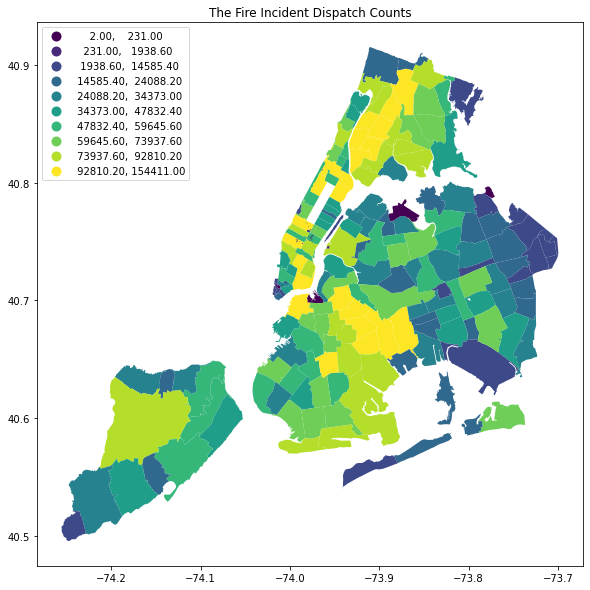

In [56]:
# plot as a heatmap with quantiles color scheme
fig, ax = plt.subplots(1, figsize=(10,10))
IncidByZip.to_crs({'init': 'epsg:4326'}).plot(ax=ax, column='N_Incident',k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})
plt.title('The Fire Incident Dispatch Counts')

Text(0.5, 1.0, 'The Fire Incident Dispatch Counts normalized by population (per 100,000)')

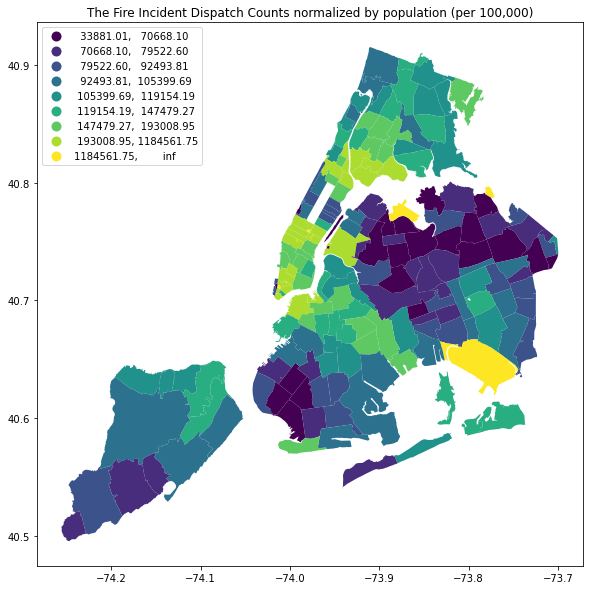

In [57]:
# plot as a heatmap with quantiles color scheme
fig, ax = plt.subplots(1, figsize=(10,10))
IncidByZip.to_crs({'init': 'epsg:4326'}).plot(ax=ax, column='IncidRate',k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})
plt.title('The Fire Incident Dispatch Counts normalized by population (per 100,000)')

#### Incident Response/Travel Time

INCIDENT_RESPONSE_SECONDS_QY: The elapsed time in seconds between the incident_datetime and the first_onscene_datetime.

INCIDENT_TRAVEL_TM_SECONDS_QY: The elapsed time in seconds between the first_assignment_datetime and the first_onscene_datetime.

DISPATCH_RESPONSE_SECONDS_QY: The elapsed time in seconds between the incident_datetime and the first_assignment_datetime.

In [58]:
total_null_onscene = IncidentsDispatch[IncidentsDispatch.FIRST_ON_SCENE_DATETIME.isnull()]['STARFIRE_INCIDENT_ID'].count()
print("Total Percentage of Missing On Scene Time", round(total_null_onscene/len(IncidentsDispatch)*100,2),"%")

Total Percentage of Missing On Scene Time 15.46 %


In [59]:
(IncidentsDispatch['INCIDENT_RESPONSE_SECONDS_QY']/60).describe().round(2)

count    9753451.00
mean           4.54
std            3.76
min            0.00
25%            3.28
50%            4.43
75%            5.68
max         4341.00
Name: INCIDENT_RESPONSE_SECONDS_QY, dtype: float64

In [60]:
(IncidentsDispatch['INCIDENT_TRAVEL_TM_SECONDS_QY']/60).describe().round(2)

count    9753419.00
mean           4.08
std            3.66
min           -1.75
25%            2.85
50%            3.93
75%            5.12
max         4340.48
Name: INCIDENT_TRAVEL_TM_SECONDS_QY, dtype: float64

The Min is negative value

In [61]:
(IncidentsDispatch['DISPATCH_RESPONSE_SECONDS_QY']/60).describe().round(2)

count    10145958.00
mean            0.49
std             0.56
min             0.00
25%             0.12
50%             0.27
75%             0.72
max             5.00
Name: DISPATCH_RESPONSE_SECONDS_QY, dtype: float64

#### Time-series exploratory analysis

In [62]:
IncidentsDispatch['INCIDENT_DATETIME'] = pd.to_datetime(IncidentsDispatch['INCIDENT_DATETIME'])
IncidentsDispatch['INCIDENT_DATE_ByDay'] = IncidentsDispatch.INCIDENT_DATETIME.dt.to_period('D')

In [63]:
IncidentsDispDaily = IncidentsDispatch[['STARFIRE_INCIDENT_ID','INCIDENT_DATE_ByDay']].groupby(by = 'INCIDENT_DATE_ByDay').count()
IncidentsDispDaily.index = IncidentsDispDaily.index.to_timestamp()
IncidentsDispDaily.head()

,STARFIRE_INCIDENT_ID
INCIDENT_DATE_ByDay,
2005-01-01,1570
2005-01-02,1165
2005-01-03,1350
2005-01-04,1180
2005-01-05,1215


In [64]:
# get the number of samples
nsamp = len(IncidentsDispDaily)

# convert the `date` feature into `dt.datetime` format. This is for later datetime operations
Time =IncidentsDispDaily.index.values

# print dataset characteristics
print('This is the original dataset characteristics:')
timeperiod = Time[-1] - Time[0] + pd.to_timedelta(1,unit='day')

# this is the duration of our observations: tail - head + 1 
print('The time period for this dataset is: ', timeperiod.days)
print('The number of observations are: ', nsamp)
print(IncidentsDispDaily.describe())

This is the original dataset characteristics:
The time period for this dataset is:  6939
The number of observations are:  6939
       STARFIRE_INCIDENT_ID
count           6939.000000
mean            1462.296440
std              243.015165
min              727.000000
25%             1281.000000
50%             1423.000000
75%             1608.000000
max             4032.000000


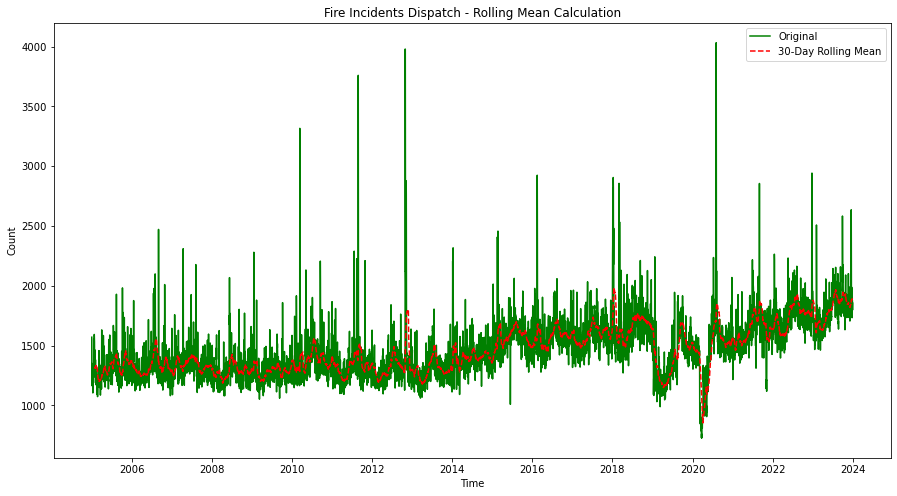

In [65]:
import matplotlib.pyplot as plt
from importlib import reload
plt = reload(plt)  # Ensure plt is reloaded, if needed

xTime = IncidentsDispDaily.index.values
yIncidents = IncidentsDispDaily['STARFIRE_INCIDENT_ID'].values

# Define the window size
window_size = 30

# Calculation of rolling mean
rolling_means = np.array([yIncidents[i:i+window_size].mean() for i in range(len(yIncidents) - window_size + 1)])
# Create a new time series for the rolling mean to align with the center of the windows
rolling_time = xTime[window_size-1:]

# Plotting
plt.figure(figsize=(15, 8))
plt.title('Fire Incidents Dispatch - Rolling Mean Calculation')
plt.plot(xTime, yIncidents, label='Original', color='green')
plt.plot(rolling_time, rolling_means, label='30-Day Rolling Mean', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()

In [66]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt

f, PSD = periodogram(IncidentsDispDaily['STARFIRE_INCIDENT_ID'])
PSD = PSD[f>0.005]
f = f[f>0.005]
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)]))

Strongest period length = 182.6052631578947


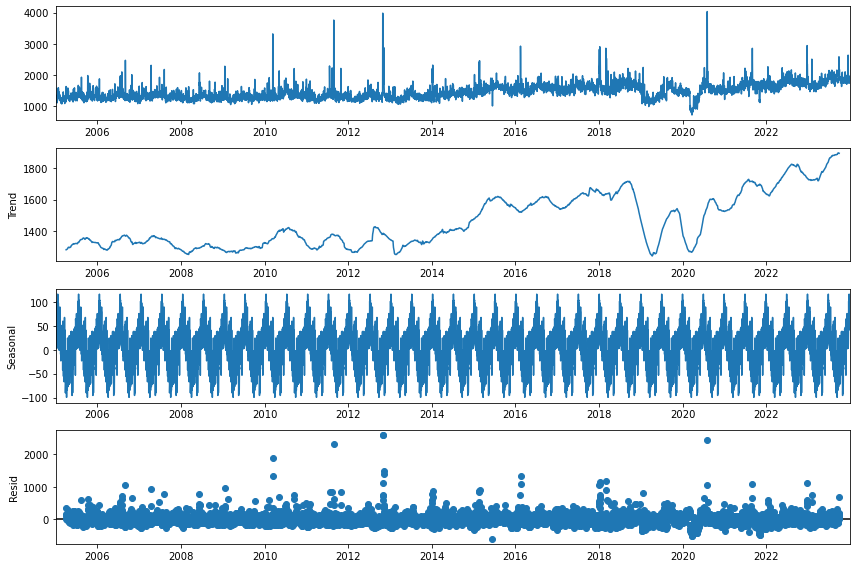

In [67]:
matplotlib.rcParams['figure.figsize'] = [12, 8]
res = sm.tsa.seasonal_decompose(IncidentsDispDaily,model='additive', period=182)
res.plot()
plt.show()

#### Predict the total daily fire incidents dispatch using ARIMA 

In [68]:
# adfuller test to test the stability of the aggregated dataset
result = adfuller(IncidentsDispDaily.values)
print('p-value: %f' % result[1])

p-value: 0.000468


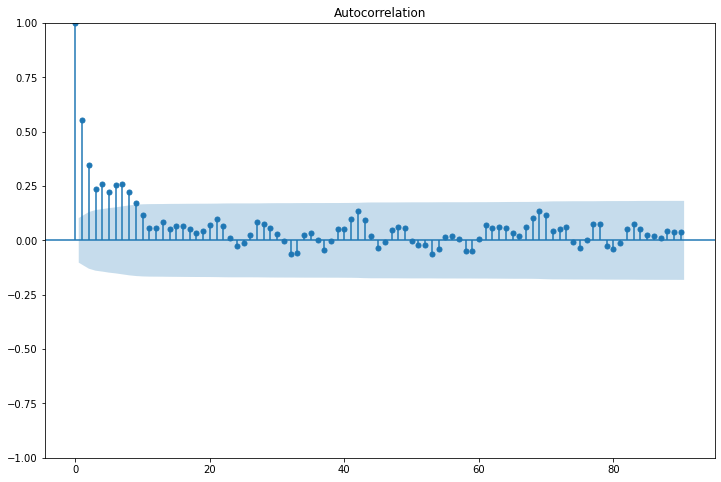

In [69]:
# Find the MA term (p)
plot_acf(IncidentsDispDaily['STARFIRE_INCIDENT_ID'][:365], lags = 90); 

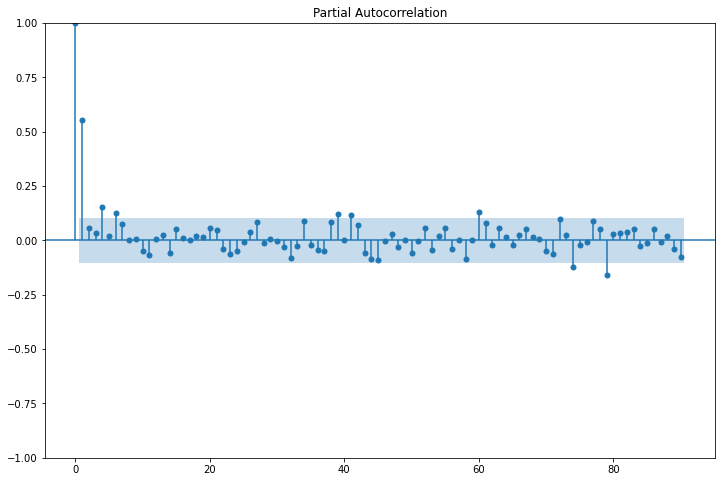

In [70]:
# Find the AR term (q)
plot_pacf(IncidentsDispDaily['STARFIRE_INCIDENT_ID'][:365], lags = 90); 

In [71]:
series = IncidentsDispDaily['STARFIRE_INCIDENT_ID']

In [72]:
train_size = int(IncidentsDispDaily.shape[0]*0.8)

                                SARIMAX Results                                 
Dep. Variable:     STARFIRE_INCIDENT_ID   No. Observations:                 5551
Model:                   ARIMA(1, 0, 1)   Log Likelihood              -35392.227
Date:                  Mon, 08 Apr 2024   AIC                          70792.453
Time:                          15:03:46   BIC                          70818.940
Sample:                      01-01-2005   HQIC                         70801.687
                           - 03-13-2020                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1409.1476     12.312    114.453      0.000    1385.016    1433.279
ar.L1          0.8633      0.006    137.023      0.000       0.851       0.876
ma.L1         -0.3095      0.008    

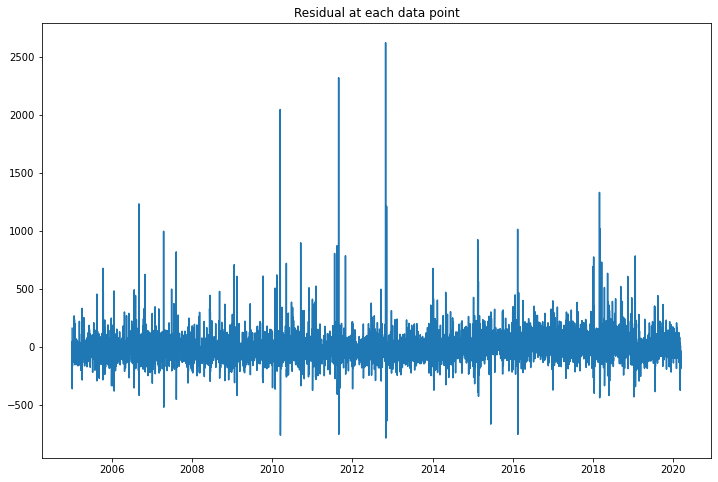

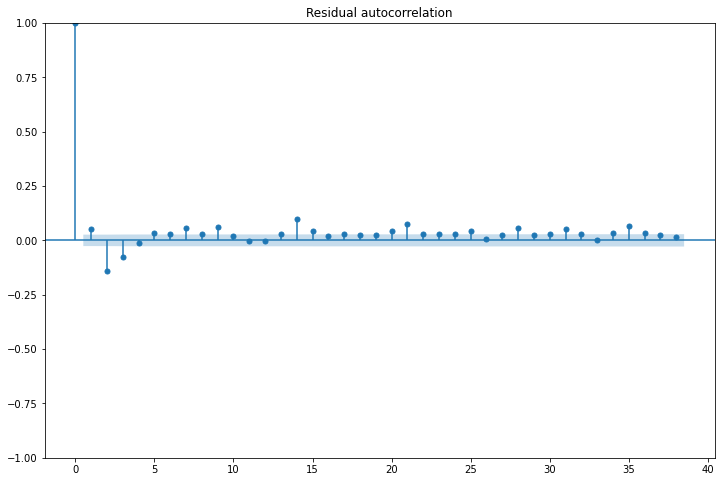

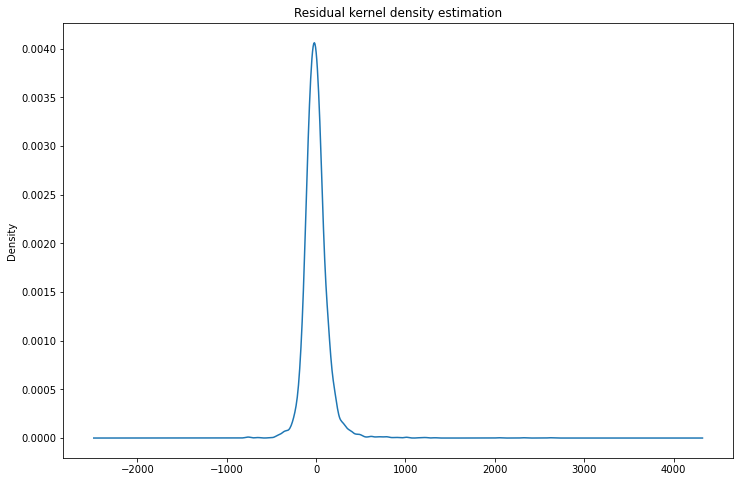

                 0
count  5551.000000
mean     -0.105807
std     142.166070
min    -784.693960
25%     -73.194360
50%     -11.349198
75%      55.578922
max    2621.301470
p value is  0.0
null hypothesis: residuals comes from a normal distribution
The null hypothesis can be rejected


In [73]:
import scipy
P=1
D=0
Q=1

# fit model
N = train_size

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# plt.figure(figsize = (6,4))
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals comes from a normal distribution')
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [74]:
# Forecast
fcast = model_fit.forecast(steps=len(series)-N)  # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()
fc_series = pd.Series(fc['mean'])
fc_series.index = IncidentsDispDaily.index[N:]

lower_series = pd.Series(fc.mean_ci_lower, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper, index=range(N,len(series)))

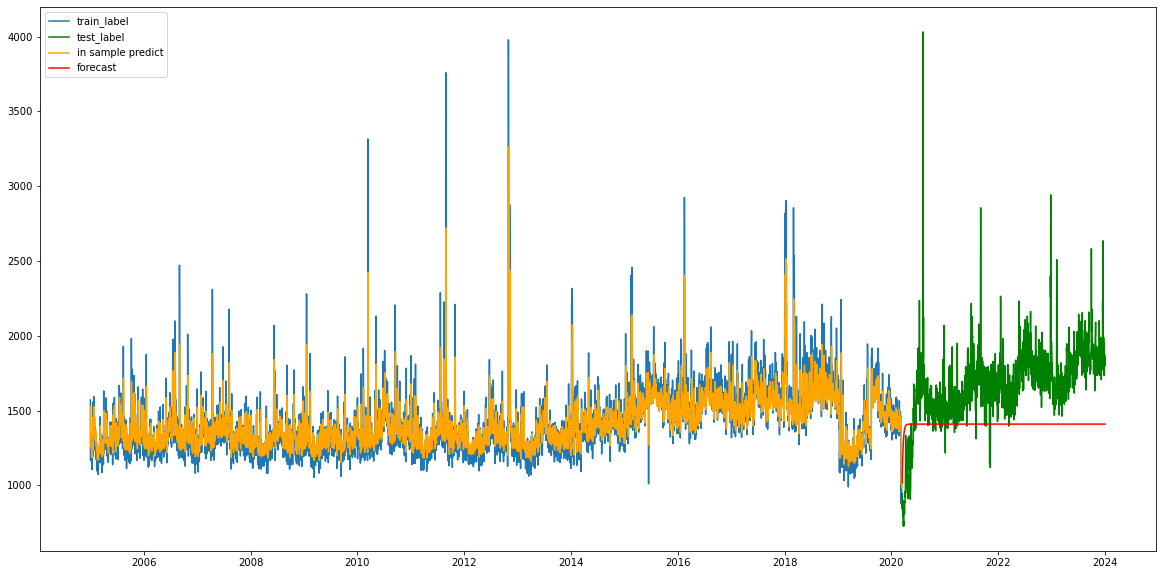

In [75]:
plt.rcParams.update({'figure.figsize':(20,10)})
# plt.plot(series)

# plt.plot(series)
plt.plot(IncidentsDispDaily.index[:N+1].values,series[:N+1].values,label='train_label')
plt.plot(IncidentsDispDaily.index[N-1:].values,series[N-1:].values,color='green',label='test_label')

plt.plot(IncidentsDispDaily.index[1:N+1].values,
         model_fit.predict(start=1,end=N,dynamic=False,typ='levels').values,
         color='orange',label='in sample predict')

plt.plot(IncidentsDispDaily.index[N:].values,
         fc_series.values.tolist(), label='forecast', color='red')
plt.legend(loc='upper left')

In [76]:
r2_score(IncidentsDispDaily[1:N+1].values,
         model_fit.predict(start=1,end=N,dynamic=False,typ='levels').values) 

0.5459399671370924

In [77]:
r2_score(IncidentsDispDaily[N:].values,
         fc_series.values.tolist()) 

-1.1262809249144734

#### Normality Test for the Noise Distributio

In [78]:
# check the distribution of a sample of data is the histogram
from numpy.random import seed
from numpy.random import randn
addResult = sm.tsa.seasonal_decompose(IncidentsDispDaily,model='additive', period=182)
residualAdd = np.array(addResult.resid)
residualAdd = residualAdd[np.logical_not(np.isnan(residualAdd))]

In [79]:
multResult = sm.tsa.seasonal_decompose(IncidentsDispDaily,model='multiplicative', period=181)
residualMult = np.log10(np.array(multResult.resid))
residualMult = residualMult[np.logical_not(np.isnan(residualMult))]

In [80]:
# Use Kolmogorov-Smirnov test to compare empirical distributions vs the normal
scipy.stats.kstest(residualAdd, 'norm')

KstestResult(statistic=0.5615059157389499, pvalue=0.0, statistic_location=-2.9179318739037363, statistic_sign=1)

In [81]:
# Use Kolmogorov-Smirnov test to compare empirical distributions vs the normal
scipy.stats.kstest(residualMult, 'norm')

KstestResult(statistic=0.45353428937430756, pvalue=0.0, statistic_location=-0.09138094954417694, statistic_sign=-1)

#### Outlier Detection on Residual

In [82]:
dailyDecomp = sm.tsa.seasonal_decompose(IncidentsDispDaily,model='multiplicative', period=182)
dailyResid = dailyDecomp.resid
outlierData = pd.DataFrame({})
outlierData['Res'] = dailyResid
outlierData['Percentile_rank'] = outlierData.Res.rank(pct = True)-0.5

In [83]:
# There is no certain definition of outliers, common methods include percentile, standard deviation, and IQR.
# In this case, we select 1% outliers.
outlier1 = IncidentsDispDaily[outlierData['Percentile_rank']>0.49]
outlier2 = IncidentsDispDaily[outlierData['Percentile_rank']<-0.49]

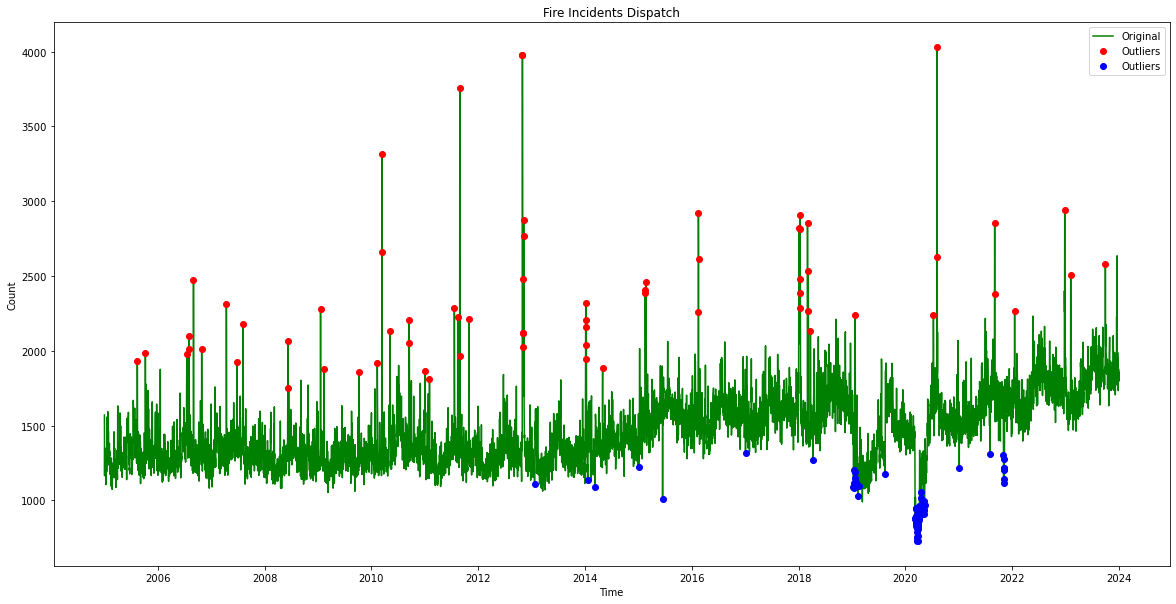

In [84]:
xTime = IncidentsDispDaily.index.values
yIncidents = IncidentsDispDaily['STARFIRE_INCIDENT_ID'].values

# Plotting
plt.figure(figsize=(20, 10))
plt.title('Fire Incidents Dispatch')
plt.plot(xTime, yIncidents, label='Original', color='green')
plt.plot(outlier1.index.values, outlier1['STARFIRE_INCIDENT_ID'].values,'ro', label='Outliers')
plt.plot(outlier2.index.values, outlier2['STARFIRE_INCIDENT_ID'].values,'bo', label='Outliers')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()

### Difference between two datasets

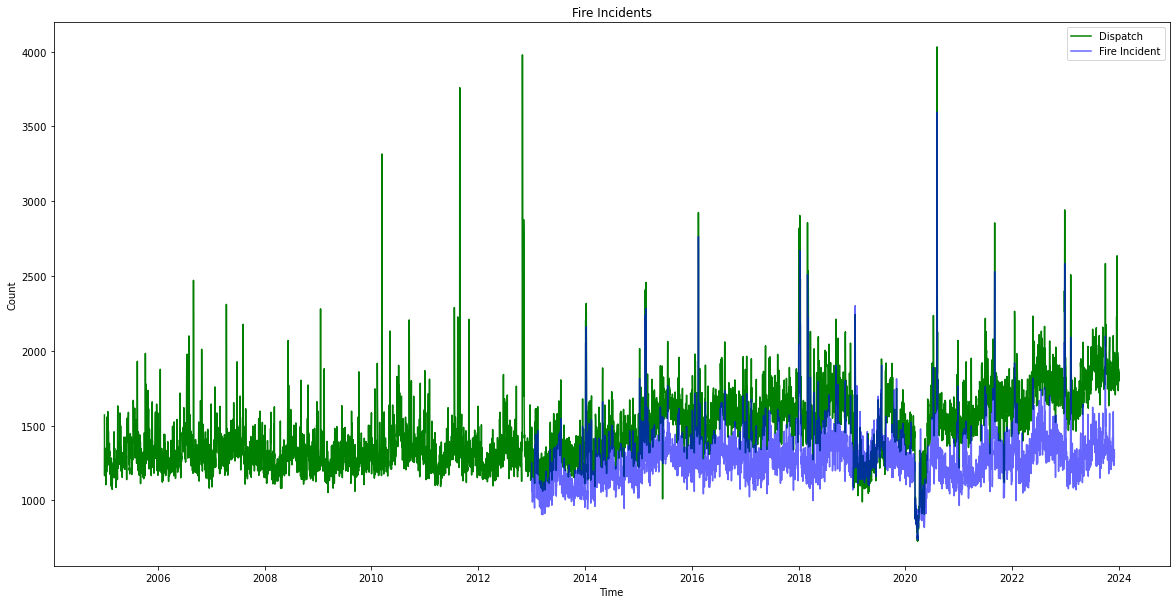

In [85]:
xTime = IncidentsDispDaily.index.values
yIncidents = IncidentsDispDaily['STARFIRE_INCIDENT_ID'].values

# Plotting
plt.figure(figsize=(20, 10))
plt.title('Fire Incidents')
plt.plot(IncidentsDispDaily.index.values, 
         IncidentsDispDaily['STARFIRE_INCIDENT_ID'].values, 
         label='Dispatch', color='green')

plt.plot(IncidentsDaily.index.values, 
         IncidentsDaily['IM_INCIDENT_KEY'].values, 
         label='Fire Incident', color='blue', alpha=0.6)

plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()

From the visual representation, it is clear that the number of dispatches (green) is systematically and significantly lower than the number of fire incidents recorded (blue). However, there are two periods of time (around 2019-Jan to 2019-Jun) and the first few months of 2020, the number of records matched well than other times.

In [88]:
combined = IncidentsDispDaily.join(IncidentsDaily, how='inner', lsuffix='_DISP', rsuffix='_INC')

In [89]:
combined['DIFFERENCE'] = combined['STARFIRE_INCIDENT_ID'] - combined['IM_INCIDENT_KEY']

In [90]:
combined.head()

,STARFIRE_INCIDENT_ID,IM_INCIDENT_KEY,DIFFERENCE
INCIDENT_DATE_ByDay,,,
2013-01-01,1489,1250,239
2013-01-02,1229,1061,168
2013-01-03,1282,1066,216
2013-01-04,1262,1079,183
2013-01-05,1215,1059,156


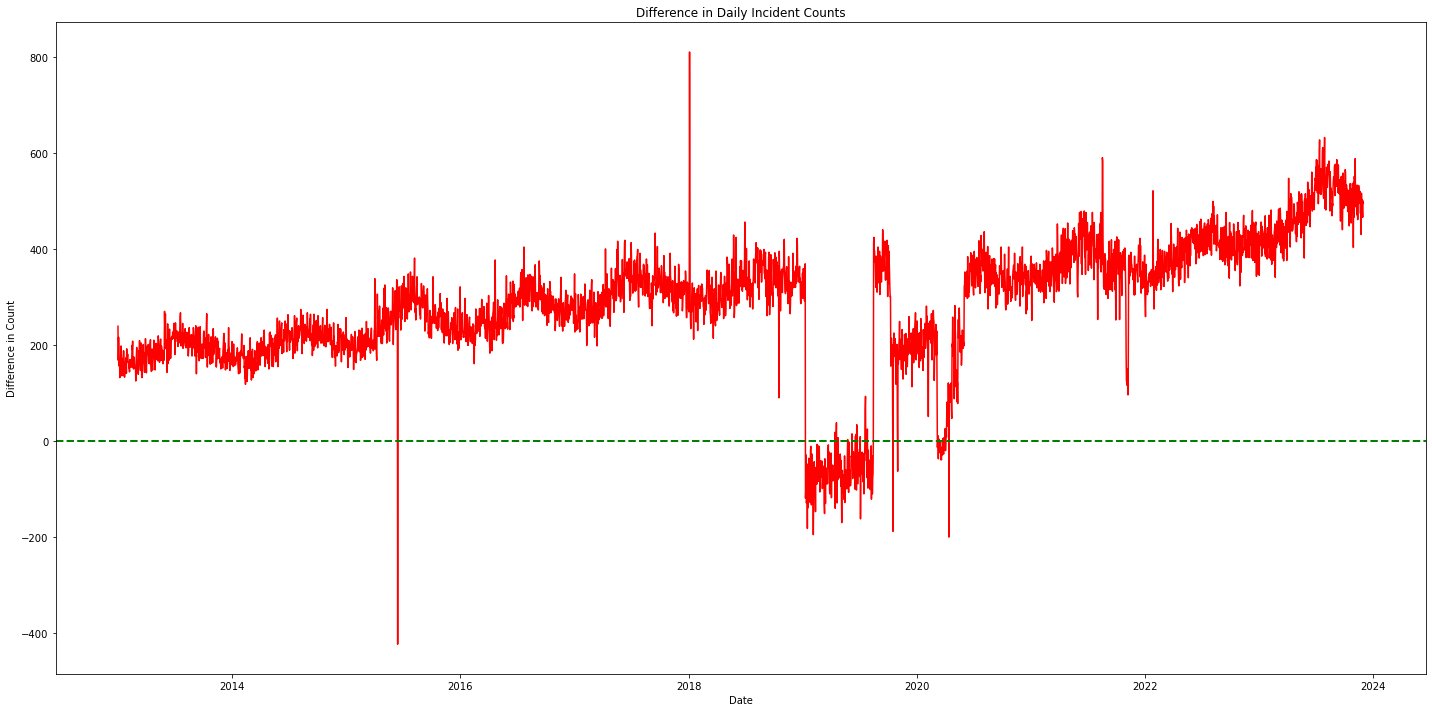

In [91]:
import matplotlib.pyplot as plt

# Plot the difference
plt.figure(figsize=(20, 10))
plt.plot(combined.index.values, 
         combined['DIFFERENCE'].values, color='red')
plt.title('Difference in Daily Incident Counts')
plt.xlabel('Date')
plt.ylabel('Difference in Count')
# Add a horizontal line at y=0
plt.axhline(y=0, color='green', linewidth=2, linestyle='--')
plt.tight_layout()
plt.show()